In [ ]:
# Run on google colab only
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/DRL-based-Recommendation'

import os
os.chdir(root_path)

In [1]:
from __future__ import print_function
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data
import matplotlib.pyplot as plt

from model import PMF
from evaluations import RMSE

In [2]:
# Input batch size for training
batch_size = 100000
# Number of maximum epoches to train
epoches = 150
# Enables CUDA training
enable_cuda = False
# Generate random seed
seed = 1
# Weight decay
weight_decay = 0.1
# Size of embedding features
embedding_feature_size = 100
# Train ratio
train_ratio = 0.8
# Val ratio
val_ratio = 0.1
# Test ratio
# test_ratio = 1 - train_ratio - val_ratio
# Learning rate
lr = 0.0001
# Momentum value
momentum = 0.9

In [24]:
# Load datasets
user = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
rest = pickle.load(open('dataset/rest_id_to_num.pkl', 'rb'))
data = np.load('dataset/data.npy', allow_pickle=True)

In [28]:
# Normalize rewards to [-1, 1]
# data[:,0] = 0.5*(data[:,0] - 3)
# print(data)

# Shuffle data
np.random.shuffle(data)

# Split data
train_data = data[:int(train_ratio*data.shape[0])]
vali_data = data[int(train_ratio*data.shape[0]):int((train_ratio+val_ratio)*data.shape[0])]
test_data = data[int((train_ratio+val_ratio)*data.shape[0]):]

# Extract number of users and items
NUM_USERS = len(user)
NUM_ITEMS = len(rest)

# Get CUDA device if available
cuda = torch.cuda.is_available() and enable_cuda

# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda else "cpu")

# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)

# Specify number of workers for cuda
kwargs = {'num_workers':4, 'pin_memory':True} if cuda else {}

# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, enable_cuda=enable_cuda)
# print(f"DEBUG: # Initialize model: n_users = {NUM_USERS}, n_items = {NUM_ITEMS}", )

# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")

# Set loss function
loss_function = nn.MSELoss(reduction='sum')

# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()

    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()

        # Extract user_id_nums: row, item_id_nums: col, ratings: val
        row = ele[:, 5]
        col = ele[:, 7]
        val = ele[:, 0]

        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())
        val = 0.5*(val - 3)

        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()

        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.data

    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

In [30]:
# training model part
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(train_ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):

    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)

    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())

    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 5]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 7]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 5]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 7]).long())

    # Normalize rewards to [-1, 1]
    vali_val = vali_data[:, 0]
    vali_val = vali_val.astype(float)
    vali_val = 0.5*(vali_val - 3)

    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)

    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())

    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_val)
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_val)

    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)

    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
              format(epoch, train_rmse, vali_rmse))

    # # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
      last_vali_rmse = vali_rmse

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:100000, epoches:150, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(1987843, 100)
  (item_embeddings): Embedding(150346, 100)
  (ub): Embedding(1987843, 1)
  (ib): Embedding(150346, 1)
)


/tmp/ipykernel_5746/2432193036.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(train_epoch_loss.cpu())


Training epoch: 1, training rmse: 0.697853, vali rmse:0.693624
Training epoch: 2, training rmse: 0.682409, vali rmse:0.683925
Training epoch: 3, training rmse: 0.671702, vali rmse:0.677132
Training epoch: 4, training rmse: 0.663399, vali rmse:0.671985
Training epoch: 5, training rmse: 0.656581, vali rmse:0.667897
Training epoch: 6, training rmse: 0.650780, vali rmse:0.664547
Training epoch: 7, training rmse: 0.645720, vali rmse:0.661736
Training epoch: 8, training rmse: 0.641226, vali rmse:0.659339
Training epoch: 9, training rmse: 0.637179, vali rmse:0.657264
Training epoch: 10, training rmse: 0.633493, vali rmse:0.655450
Training epoch: 11, training rmse: 0.630105, vali rmse:0.653848
Training epoch: 12, training rmse: 0.626969, vali rmse:0.652422
Training epoch: 13, training rmse: 0.624045, vali rmse:0.651145
Training epoch: 14, training rmse: 0.621304, vali rmse:0.649995
Training epoch: 15, training rmse: 0.618723, vali rmse:0.648953
Training epoch: 16, training rmse: 0.616281, vali

------------------------------------------- Testing Model------------------------------------------------
Test rmse: 0.635396


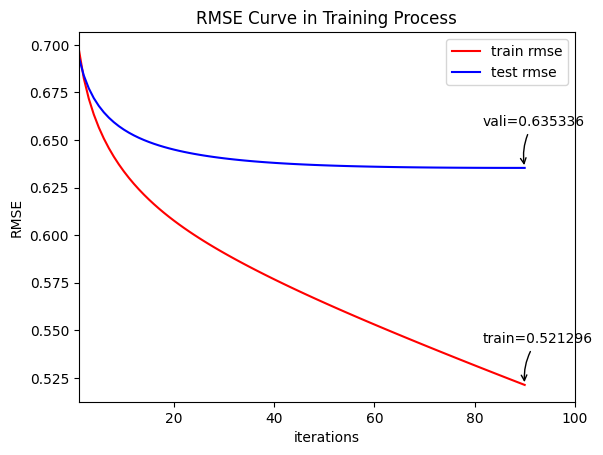

In [33]:
print('------------------------------------------- Testing Model------------------------------------------------')

# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 5]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 7]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 5]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 7]).long())

# Get test predictions
preds = model.predict(test_row, test_col)

# Normalize rewards to [-1, 1]
test_val = test_data[:, 0]
test_val = test_val.astype(float)
test_val = 0.5*(test_val - 3)

# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_val)
else:
    test_rmse = RMSE(preds.data.numpy(), test_val)
print('Test rmse: {:f}'.format(test_rmse))

# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()

# Save model
path_to_trained_pmf = 'dataset/data_runs/ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_cuda_{:}_trained_pmf.pt'.format(train_ratio, batch_size, len(train_rmse_list), weight_decay, lr, enable_cuda)
torch.save(model.state_dict(), path_to_trained_pmf)